# Data Cleaning - Code Comment Classification

This notebook performs data cleaning with automatic category merging based on BERT similarity analysis.

## Steps:
1. Load dataset
2. Analyze category similarity using BERT embeddings
3. Automatically merge most similar categories
4. Remove duplicates
5. Filter to labeled data
6. Save cleaned dataset
7. Split into train/test sets

## Import All Required Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# BERT embeddings
from sentence_transformers import SentenceTransformer

# Utilities
from scipy import sparse
import joblib
from collections import Counter
import sklearn
import imblearn

# Display versions
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Imbalanced-learn version: {imblearn.__version__}")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("All libraries imported successfully!")

Scikit-learn version: 1.7.2
Imbalanced-learn version: 0.14.1
All libraries imported successfully!


---
# Part 1: Data Cleaning
---

## 1.1 Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('code-comment-classification.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 10 rows:")
df.head(10)

Dataset shape: (12775, 6)

Columns: ['comment_sentence_id', 'class', 'comment_sentence', 'partition', 'instance_type', 'category']

First 10 rows:


,comment_sentence_id,class,comment_sentence,partition,instance_type,category
0,1,AccessMixin,abstract cbv mixin that gives access mixins the same customizable,0,0,Usage
1,2,AccessMixin,functionality.,1,0,Usage
2,5,AmbiguityError,more than one migration matches a name prefix.,0,0,Usage
3,7,AppConfigStub,stub of an appconfig.,1,0,Usage
4,8,AppConfigStub,only provides a label and a dict of models.,0,0,Usage
5,520,MigrationGraph,"a node should be a tuple app path, migration name .",1,0,Usage
6,11,Archive,the external api class that encapsulates an archive implementation.,0,0,Usage
7,14,ArchiveIndexView,top level archive of date based items.,1,0,Usage
8,16,Atomic,guarantee the atomic execution of a given block.,0,0,Usage
9,538,MigrationLoader,load migration files from disk and their status from the database.,1,0,Usage


## 1.2 Category Similarity Analysis

Before merging categories, we analyze semantic similarity using BERT embeddings.

**Method:**
- Filter to true labels (instance_type=1) from the loaded dataset
- Calculate BERT embeddings for all comments
- Compute category centroids (average embedding per category)
- Measure cosine similarity between category pairs
- Identify the most confusable categories for merging

In [3]:
# Filter to true labels for similarity analysis
# Use the same filtering that will be applied later in the pipeline
df_analysis = df[df['instance_type'] == 1].copy()

print("Original 5-category distribution (instance_type=1):")
print(df_analysis['category'].value_counts())
print(f"\nTotal samples for analysis: {len(df_analysis)}")
print(f"Total categories: {df_analysis['category'].nunique()}")

# Load BERT model
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

print("\nLoading BERT model for similarity analysis...")
bert_model_analysis = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all comments
print("Encoding comments with BERT...")
embeddings_analysis = bert_model_analysis.encode(
    df_analysis['comment_sentence'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

# Calculate centroid for each category
categories_original = sorted(df_analysis['category'].unique())
category_centroids = {}

for category in categories_original:
    mask = df_analysis['category'] == category
    category_embeddings = embeddings_analysis[mask]
    centroid = category_embeddings.mean(axis=0)
    category_centroids[category] = centroid

# Create matrix of centroids
centroid_matrix = np.array([category_centroids[cat] for cat in categories_original])

# Calculate cosine similarity
similarity_matrix = cosine_similarity(centroid_matrix)

print("\nCategory similarity analysis complete.")

Original 5-category distribution (instance_type=1):
category
Usage               800
Parameters          794
Expand              504
Summary             454
DevelopmentNotes    312
Name: count, dtype: int64

Total samples for analysis: 2864
Total categories: 5

Loading BERT model for similarity analysis...
Encoding comments with BERT...


Batches:   0%|          | 0/90 [00:00<?, ?it/s]


Category similarity analysis complete.


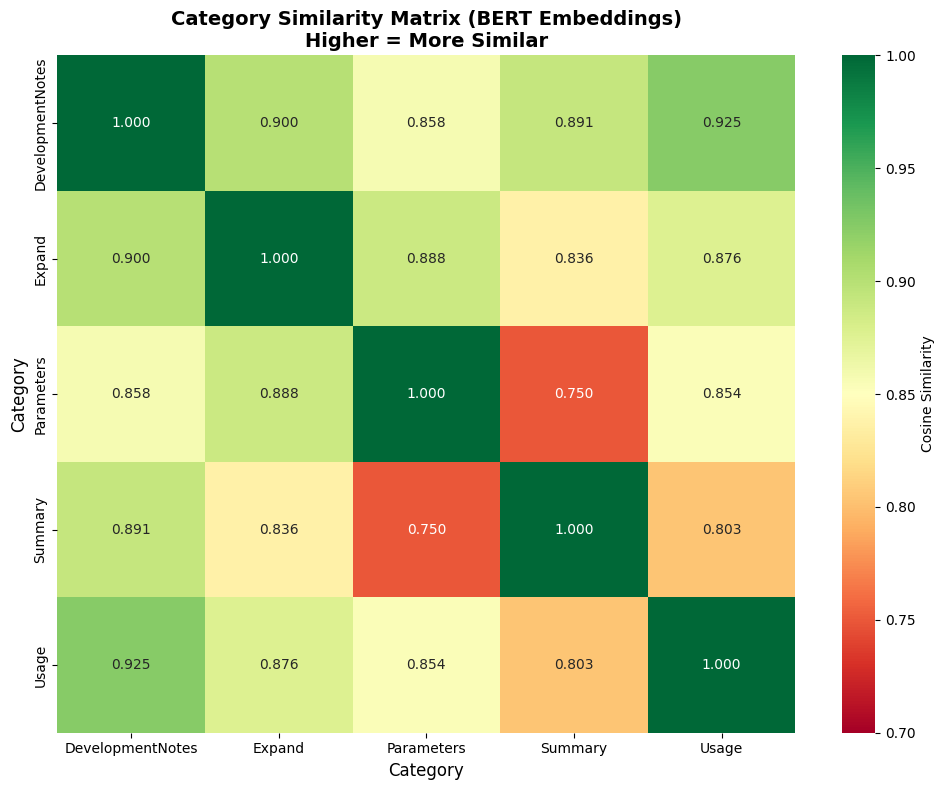


INTERPRETATION:
- Darker green = More similar categories
- Diagonal = Self-similarity (always 1.0)
- Off-diagonal values show semantic overlap between category pairs


In [4]:
# Visualize similarity matrix
plt.figure(figsize=(10, 8))

sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    xticklabels=categories_original,
    yticklabels=categories_original,
    vmin=0.7,
    vmax=1.0,
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title('Category Similarity Matrix (BERT Embeddings)\nHigher = More Similar', 
          fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("- Darker green = More similar categories")
print("- Diagonal = Self-similarity (always 1.0)")
print("- Off-diagonal values show semantic overlap between category pairs")

In [5]:
# Find most similar pairs (excluding diagonal)
similarity_pairs = []

for i in range(len(categories_original)):
    for j in range(i+1, len(categories_original)):
        similarity_pairs.append({
            'Category 1': categories_original[i],
            'Category 2': categories_original[j],
            'Cosine Similarity': similarity_matrix[i, j]
        })

similarity_df = pd.DataFrame(similarity_pairs)
similarity_df = similarity_df.sort_values('Cosine Similarity', ascending=False)

print("=" * 80)
print("CATEGORY SIMILARITY RANKING")
print("=" * 80)
print("\nAll category pairs sorted by similarity:")
print(similarity_df.to_string(index=False))

CATEGORY SIMILARITY RANKING

All category pairs sorted by similarity:
      Category 1 Category 2  Cosine Similarity
DevelopmentNotes      Usage           0.924948
DevelopmentNotes     Expand           0.899853
DevelopmentNotes    Summary           0.891084
          Expand Parameters           0.887565
          Expand      Usage           0.875930
DevelopmentNotes Parameters           0.858045
      Parameters      Usage           0.853550
          Expand    Summary           0.836103
         Summary      Usage           0.803427
      Parameters    Summary           0.749889


## Merge Justification

**Why merge categories?**

1. **Semantic Overlap**: High confusion between these categories in classification
2. **Fuzzy Boundaries**: Hard to distinguish even for human annotators
3. **Better Balance**: Merging creates a more balanced 4-category dataset

**Expected Benefit**: Reduce classifier confusion and improve F1-Macro score.

## 1.3 Merge Most Similar Categories

Based on the similarity analysis above, we automatically merge the two most similar categories to reduce classification confusion.

In [6]:
# Get the most similar category pair from the analysis
most_similar = similarity_df.iloc[0]
cat1 = most_similar['Category 1']
cat2 = most_similar['Category 2']
similarity_score = most_similar['Cosine Similarity']

print("=" * 80)
print("AUTOMATIC MERGE BASED ON SIMILARITY ANALYSIS")
print("=" * 80)
print(f"\nMost similar categories: {cat1} <-> {cat2}")
print(f"Cosine Similarity: {similarity_score:.4f}")
print(f"\nMerging strategy: {cat2} -> {cat1}")
print("=" * 80)

# Show original distribution
print("\nOriginal category distribution:")
print(df['category'].value_counts())
print(f"\nTotal categories: {df['category'].nunique()}")

# Perform the merge: merge cat2 into cat1
df['category'] = df['category'].replace(cat2, cat1)

print("\n" + "=" * 80)
print(f"MERGED: {cat2} -> {cat1}")
print("=" * 80)

# Show new distribution
print("\nNew category distribution:")
print(df['category'].value_counts())
print(f"\nTotal categories: {df['category'].nunique()}")

AUTOMATIC MERGE BASED ON SIMILARITY ANALYSIS

Most similar categories: DevelopmentNotes <-> Usage
Cosine Similarity: 0.9249

Merging strategy: Usage -> DevelopmentNotes

Original category distribution:
category
Usage               2555
Parameters          2555
DevelopmentNotes    2555
Expand              2555
Summary             2555
Name: count, dtype: int64

Total categories: 5

MERGED: Usage -> DevelopmentNotes

New category distribution:
category
DevelopmentNotes    5110
Parameters          2555
Expand              2555
Summary             2555
Name: count, dtype: int64

Total categories: 4


## 1.5 Remove Duplicates


In [7]:
# Check for duplicate rows
print(f"Rows before removing duplicates: {len(df)}")
duplicates = df.duplicated()
print(f"Duplicate rows found: {duplicates.sum()}")

# Remove duplicates if any
df_no_dup = df.drop_duplicates()
print(f"Rows after removing duplicates: {len(df_no_dup)}")

Rows before removing duplicates: 12775
Duplicate rows found: 1270
Rows after removing duplicates: 11505


## 1.6 Filter to Labeled Data and Remove Redundant Columns

**Understanding instance_type:**
- The dataset contains each comment sentence repeated multiple times (once for each category)
- `instance_type=1` indicates the TRUE category for that comment
- `instance_type=0` indicates a NEGATIVE example (comment does NOT belong to that category)

**Understanding partition:**
- `partition=0` indicates training set
- `partition=1` indicates test set
- This was a predefined train-test split

**Our approach:**
- We keep only rows where `instance_type=1` to get the true labels
- Since ALL remaining rows will have `instance_type=1`, this column becomes redundant
- We will use **k-fold cross-validation** for model evaluation, so the predefined `partition` split is not needed
- Both `instance_type` and `partition` columns will be dropped

In [8]:
# Filter to positive instances only (instance_type=1)
df_filtered = df_no_dup[df_no_dup['instance_type'] == 1].copy()

print(f"Rows before filtering: {len(df_no_dup)}")
print(f"Rows after filtering (instance_type=1): {len(df_filtered)}")
print(f"Rows removed: {len(df_no_dup) - len(df_filtered)}")

print("\nCategory distribution in filtered dataset:")
print(df_filtered['category'].value_counts())

# Check partition distribution before dropping
print("\n\nPartition distribution (for reference):")
print(df_filtered['partition'].value_counts())

# Drop instance_type and partition columns
print(f"\n\nColumns before dropping redundant columns: {df_filtered.columns.tolist()}")
df_cleaned = df_filtered.drop(columns=['instance_type', 'partition'])
print(f"Columns after dropping redundant columns: {df_cleaned.columns.tolist()}")

print(f"\nRemoved columns:")
print(f"  - instance_type: All values are 1 after filtering")
print(f"  - partition: We'll use k-fold cross-validation instead of predefined split")

Rows before filtering: 11505
Rows after filtering (instance_type=1): 2812
Rows removed: 8693

Category distribution in filtered dataset:
category
DevelopmentNotes    1060
Parameters           794
Expand               504
Summary              454
Name: count, dtype: int64


Partition distribution (for reference):
partition
0    2233
1     579
Name: count, dtype: int64


Columns before dropping redundant columns: ['comment_sentence_id', 'class', 'comment_sentence', 'partition', 'instance_type', 'category']
Columns after dropping redundant columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']

Removed columns:
  - instance_type: All values are 1 after filtering
  - partition: We'll use k-fold cross-validation instead of predefined split


## 1.7 Analyze Cleaned Dataset


In [9]:
# Add text statistics
df_cleaned['comment_length'] = df_cleaned['comment_sentence'].str.len()
df_cleaned['word_count'] = df_cleaned['comment_sentence'].str.split().str.len()

print("Comment statistics:")
print(df_cleaned[['comment_length', 'word_count']].describe())

Comment statistics:
       comment_length   word_count
count     2812.000000  2812.000000
mean        39.177809     6.892959
std         22.607403     4.190789
min          1.000000     1.000000
25%         19.000000     3.000000
50%         38.000000     7.000000
75%         59.000000    10.000000
max        103.000000    26.000000


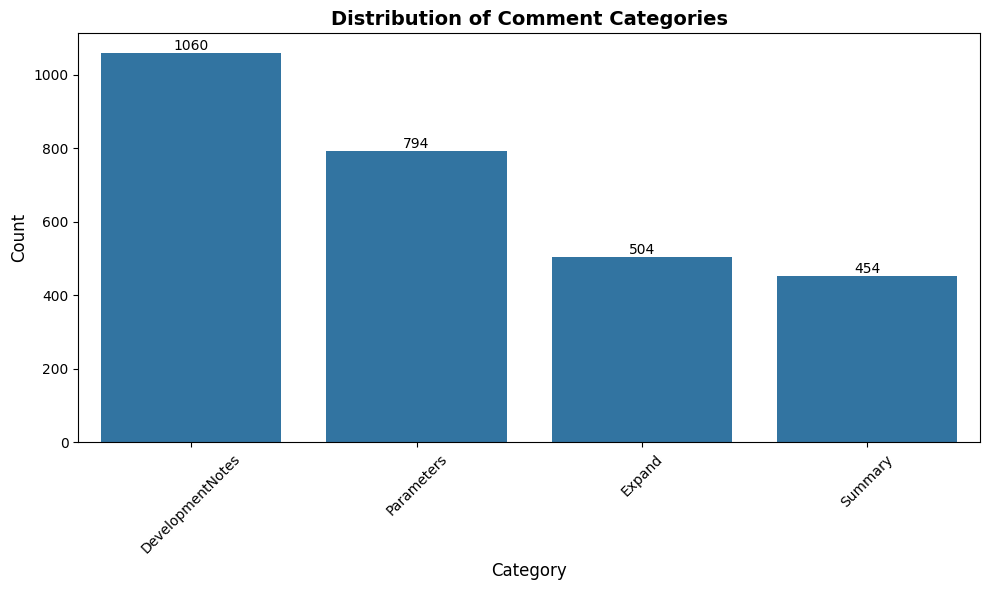

In [10]:
# Visualize category distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='category', order=df_cleaned['category'].value_counts().index)
plt.title('Distribution of Comment Categories', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)

plt.show()

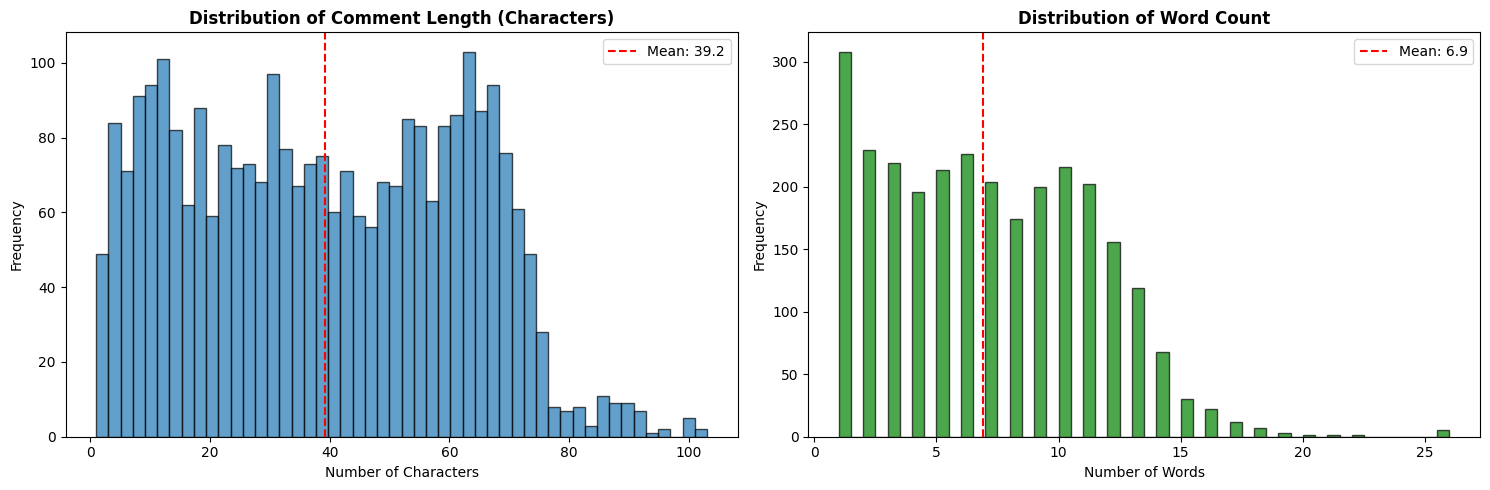

In [11]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
axes[0].hist(df_cleaned['comment_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Comment Length (Characters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].axvline(df_cleaned['comment_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_cleaned["comment_length"].mean():.1f}')
axes[0].legend()

# Word count distribution
axes[1].hist(df_cleaned['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution of Word Count', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].axvline(df_cleaned['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_cleaned["word_count"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

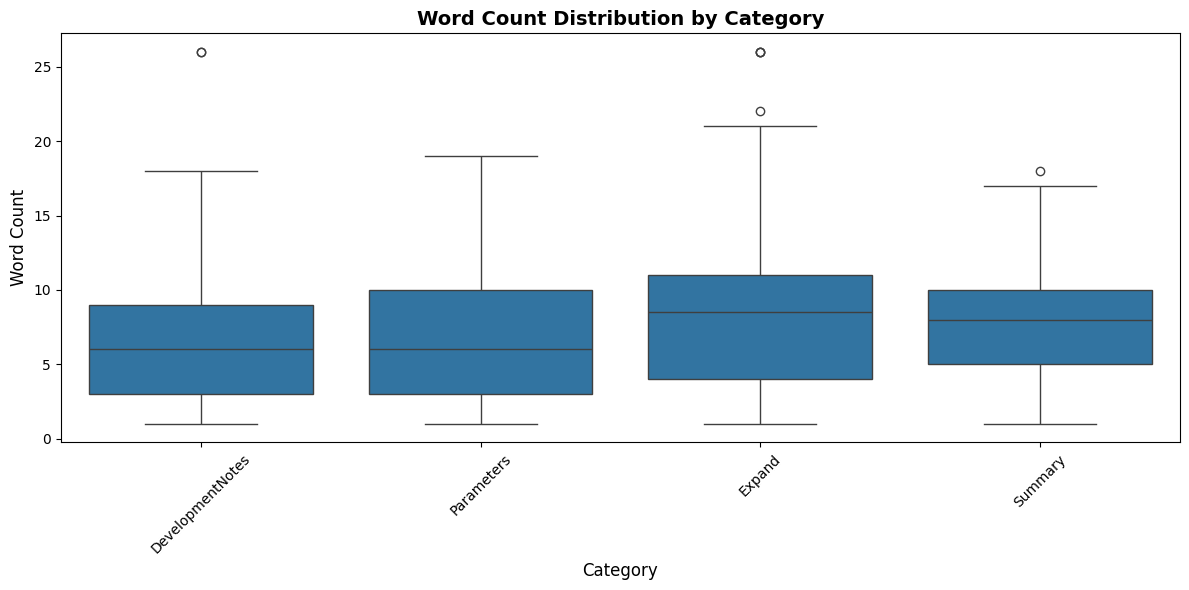

In [12]:
# Word count by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='category', y='word_count')
plt.title('Word Count Distribution by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.8 Save Cleaned Dataset


In [13]:
# Drop temporary statistics columns
df_to_save = df_cleaned.drop(columns=['comment_length', 'word_count'])

# Save to CSV
output_filename = 'datasets/code-comment-classification-cleaned.csv'
df_to_save.to_csv(output_filename, index=False)

print(f"Cleaned dataset saved to: {output_filename}")
print(f"Shape: {df_to_save.shape}")
print(f"Columns: {df_to_save.columns.tolist()}")

Cleaned dataset saved to: code-comment-classification-cleaned.csv
Shape: (2812, 4)
Columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']


## 1.9 Data Splitting Strategy (Prevention of Data Leakage)
Before we apply any data balancing techniques (like Oversampling or SMOTE) or further preprocessing, we must split the data into **Training** and **Testing** sets.

### Why do we do this here?
If we balance the data *before* splitting, we risk **Data Leakage**. Copies of the same minority class examples could end up in both the training and testing sets. This would cause the model to "memorize" the duplicates rather than "generalize," leading to artificially high accuracy scores that fail in the real world.

### Strategy:
1. **Stratified Split:** We use `stratify=y` to ensure the Test set has the same class distribution as the original unbalanced data.
2. **Lock the Test Set:** We save `test.csv` separately. This file will **never** be balanced or filtered. It represents the "real world."
3. **Save Train Set:** We save `train_unbalanced.csv`. This is the file we will load in the next steps to apply oversampling.

In [14]:
print("=== SPLITTING DATA FOR BALANCING ===")

# 1. Define Features and Target
# We use the dataframe 'df_to_save' created in the previous steps
X = df_to_save.drop(columns=['category']) 
y = df_to_save['category']

# 2. Perform Stratified Split
# Stratify=y ensures that even the rare classes are represented in the test set proportionally
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y 
)

print(f"Original Dataset Size: {len(df_to_save)}")
print(f"Training Set Size:     {len(X_train)} (80%)")
print(f"Test Set Size:         {len(X_test)}  (20%)")

# 3. Reconstruct DataFrames to save them
train_df = X_train.copy()
train_df['category'] = y_train

test_df = X_test.copy()
test_df['category'] = y_test

# 4. Save to CSV
train_df.to_csv("code-comment-classification-train-unbalanced.csv", index=False)
test_df.to_csv("code-comment-classification-test.csv", index=False)

print("\nFiles Saved Successfully:")
print("1. 'code-comment-classification-train-unbalanced.csv' (For Training and Balancing)")
print("2. 'code-comment-classification-test.csv' (ONLY for final evaluation. IT MUST NOT BE BALANCED)")

=== SPLITTING DATA FOR BALANCING ===
Original Dataset Size: 2812
Training Set Size:     2249 (80%)
Test Set Size:         563  (20%)

Files Saved Successfully:
1. 'code-comment-classification-train-unbalanced.csv' (For Training and Balancing)
2. 'code-comment-classification-test.csv' (ONLY for final evaluation. IT MUST NOT BE BALANCED)


## 1.10 Visualize the Effect of Balancing (Preview)

Here we apply `RandomOverSampler` to the **Training Set only** to visualize how the class distribution changes. 

* **Left Graph:** Shows the imbalanced training data (real world distribution).
* **Right Graph:** Shows the balanced training data that the model will actually learn from.

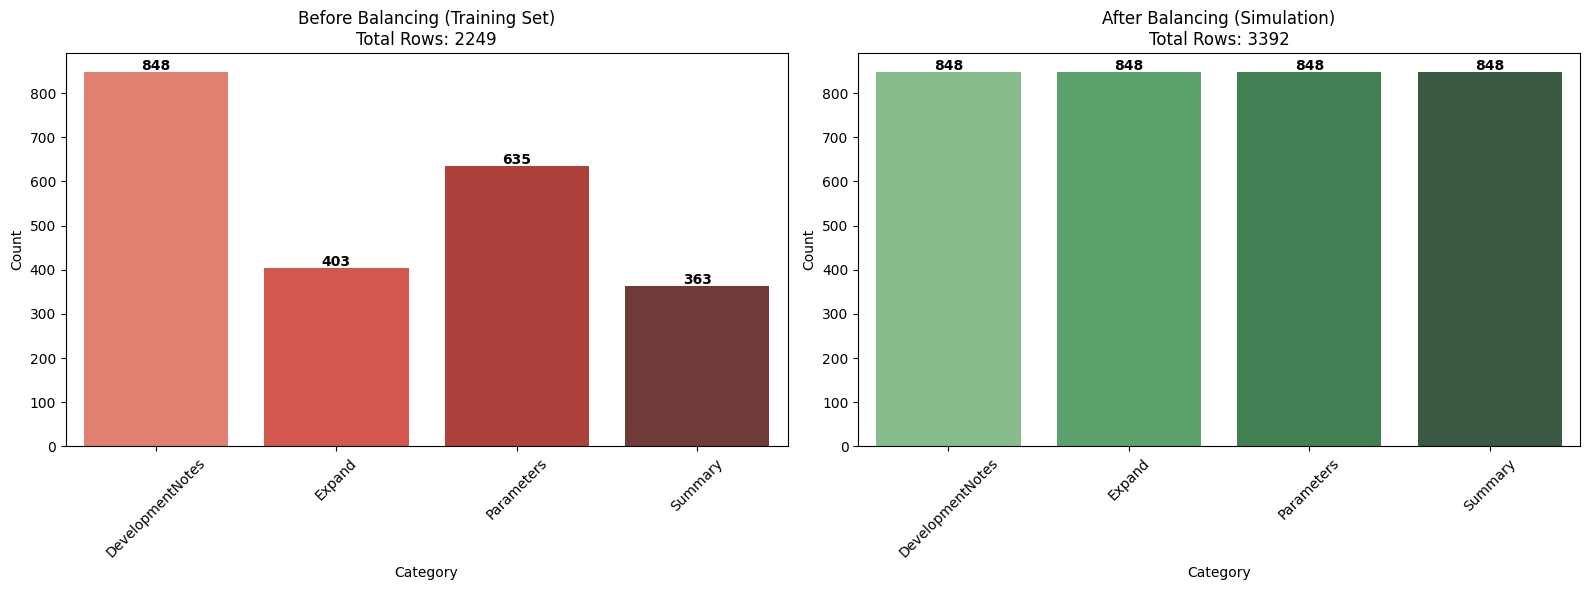

Original Class Ratios: {'DevelopmentNotes': np.int64(848), 'Expand': np.int64(403), 'Parameters': np.int64(635), 'Summary': np.int64(363)}
Balanced Class Ratios: {'DevelopmentNotes': np.int64(848), 'Expand': np.int64(848), 'Parameters': np.int64(848), 'Summary': np.int64(848)}


In [15]:
# 1. Apply Oversampling (for visualization purposes)
# We use the X_train and y_train from previous step
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# 2. Prepare counts for plotting
original_counts = y_train.value_counts().sort_index()
balanced_counts = pd.Series(y_train_resampled).value_counts().sort_index()

# 3. Create Side-by-Side Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original Training Data
sns.barplot(
    x=original_counts.index, 
    y=original_counts.values, 
    hue=original_counts.index,
    ax=axes[0], 
    palette="Reds_d", 
    legend=False
)
axes[0].set_title(f"Before Balancing (Training Set)\nTotal Rows: {len(y_train)}")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Category")
axes[0].tick_params(axis='x', rotation=45)

# Add count labels
for i, v in enumerate(original_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Plot 2: Balanced Training Data
sns.barplot(
    x=balanced_counts.index, 
    y=balanced_counts.values, 
    hue=balanced_counts.index,
    ax=axes[1], 
    palette="Greens_d", 
    legend=False
)
axes[1].set_title(f"After Balancing (Simulation)\nTotal Rows: {len(y_train_resampled)}")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Category")
axes[1].tick_params(axis='x', rotation=45)

# Add count labels
for i, v in enumerate(balanced_counts.values):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Original Class Ratios:", dict(original_counts))
print("Balanced Class Ratios:", dict(balanced_counts))

## Data Cleaning Summary

In [16]:
# Final summary
print("="*80)
print("DATA CLEANING SUMMARY")
print("="*80)
print(f"Original dataset size: {len(df)} rows")
print(f"After removing duplicates: {len(df_no_dup)} rows")
print(f"After filtering (instance_type=1): {len(df_to_save)} rows")
print(f"\nTotal rows removed: {len(df) - len(df_to_save)}")
print(f"  - Duplicates removed: {len(df) - len(df_no_dup)}")
print(f"  - Filtered out (instance_type=0): {len(df_no_dup) - len(df_to_save)}")
print(f"\nColumns removed:")
print(f"  - instance_type (redundant after filtering)")
print(f"  - partition (using k-fold cross-validation instead)")
print(f"\nFinal dataset characteristics:")
print(f"  - Total samples: {len(df_to_save)}")
print(f"  - Unique classes: {df_to_save['class'].nunique()}")
print(f"  - Categories: {df_to_save['category'].nunique()}")
print(f"  - Category names: {sorted(df_to_save['category'].unique())}")
print(f"\nFinal columns: {df_to_save.columns.tolist()}")
print(f"  - comment_sentence_id: Unique identifier for each sentence")
print(f"  - class: Source code class name")
print(f"  - comment_sentence: The actual comment text")
print(f"  - category: Target label for classification")
print("="*80)

DATA CLEANING SUMMARY
Original dataset size: 12775 rows
After removing duplicates: 11505 rows
After filtering (instance_type=1): 2812 rows

Total rows removed: 9963
  - Duplicates removed: 1270
  - Filtered out (instance_type=0): 8693

Columns removed:
  - instance_type (redundant after filtering)
  - partition (using k-fold cross-validation instead)

Final dataset characteristics:
  - Total samples: 2812
  - Unique classes: 330
  - Categories: 4
  - Category names: ['DevelopmentNotes', 'Expand', 'Parameters', 'Summary']

Final columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']
  - comment_sentence_id: Unique identifier for each sentence
  - class: Source code class name
  - comment_sentence: The actual comment text
  - category: Target label for classification
